In [34]:
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import mne
import numpy as np
import pandas as pd
import pyxdf

In [35]:
# setup logging
# set to ERROR to suppress warnings about empty streams

import logging
logFormatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

In [36]:
# load data 

def load_data(path: str):
    tmp = []
    for file in glob.glob(path, recursive=True):
        tmp.append(file)
    return tmp


# load baseline file names
baseline_list = load_data('data/**/*S001*.xdf')
current_baseline_list = [x for x in baseline_list if 'Tobias' in x]
print(current_baseline_list)

# load experiment file names
experiment_list = load_data('data/**/*S002*.xdf')
current_experiment_list = [x for x in experiment_list if 'Tobias' in x]
print(current_experiment_list)


['data/gme2022/sub-Tobias/ses-S001/eeg/sub-Tobias_ses-S001_task-Default_run-001_eeg.xdf']
['data/gme2022/sub-Tobias/ses-S002/eeg/sub-Tobias_ses-S002_task-Default_run-001_eeg.xdf']


In [37]:
# read baseline function

def read_baseline(current_baseline_list):

    current_baseline_mne_list = []

    sfreq = 250
    info = mne.create_info(8, sfreq, ["eeg"] * 8)

    for baseline in current_baseline_list:
        streams, _ = pyxdf.load_xdf(baseline)
        try:
            data = streams[1]["time_series"].T[:8]
        except AttributeError:
            # some recordings miss the marker channel
            data = streams[0]["time_series"].T[:8]
        raw = mne.io.RawArray(data, info, verbose=False)
        raw = raw.crop(tmin=1, tmax=41)
        current_baseline_mne_list.append(raw)
    return current_baseline_mne_list

current_baseline_mne_list = read_baseline(current_baseline_list)
print(current_baseline_mne_list)

[<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>]


In [38]:
# read trials

def read_trails(current_experiment_list: list, current_baseline_list: list) -> dict:

    trials = { 
            'ball': list(),
            'ball+number': list(),
            'ball+number+wheel': list(),
            'baseline': read_baseline(current_baseline_list),
            }

    for experiment in current_experiment_list:
        streams, _ = pyxdf.load_xdf(experiment)
        marker = -1 
        eeg = -1
        for idx, stream in enumerate(streams):
            if streams[idx]['time_stamps'].shape[0] == 0:
                continue # ignore empty streams
            if stream["info"]["name"] == ["markers"]:
                marker = idx
            elif stream["info"]["name"] == ["eeg"]:
                eeg = idx
            else:
                raise Exception(f"stream info name unknown {stream['info']['name']}")

        if marker == -1 or eeg == -1:
            raise Exception('channels not found') # eeg or marker stream not found
        
        for i in range(0, streams[marker]["time_stamps"].shape[0], 2):
            event = streams[marker]["time_series"][i][0]
            if event in ['Starting Complex Eye Tracking Dashboard', 'Starting Simple Eye Tracking Dashboard', '']:
                continue
            start = streams[marker]["time_stamps"][i]
            stop = streams[marker]["time_stamps"][i+1]

            data = []
            for j, stamp in enumerate(streams[eeg]["time_stamps"]):
                if start <= stamp and stamp <= stop: 
                    data.append(streams[eeg]["time_series"][j])
            data = np.array(data).T[:8]

            sfreq = 250
            info = mne.create_info(8, sfreq, ["eeg"] * 8)
            trial = mne.io.RawArray(data, info, verbose=False)

            if event == 'Starting Cognitive Load Tasks: Balls True, Numbers False, Wheel False':
                key = 'ball'
            elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel False':
                key = 'ball+number'
            elif event == 'Starting Cognitive Load Tasks: Balls True, Numbers True, Wheel True':
                key = 'ball+number+wheel'
            else:
                print(f"key {event} not defined!")

            trials[key].append(trial)
        
    return trials

trials = read_trails(current_experiment_list, current_baseline_list) 

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1353420/2178737573.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=125);


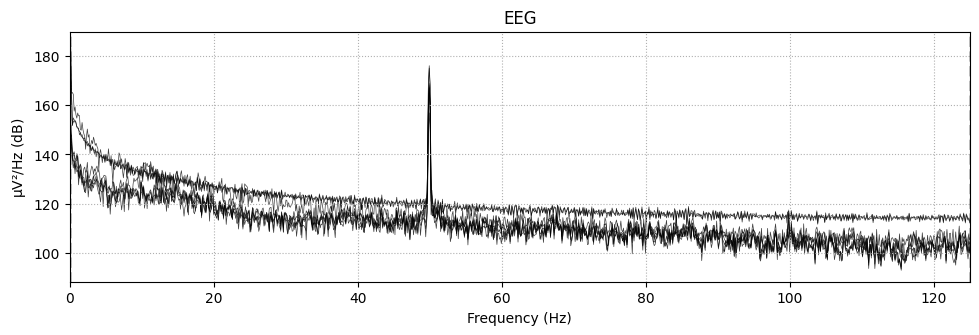

In [39]:
# plot psd with power line noise

raw = current_baseline_mne_list[0]
raw.plot_psd(tmax=np.inf, fmax=125);


Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/tmp/ipykernel_1353420/2465015595.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_notch.plot_psd(tmax=np.inf, fmax=125);


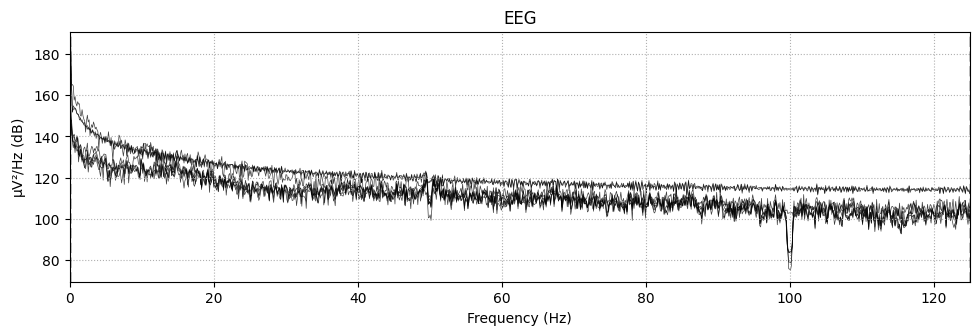

In [40]:
# filter power line noise and plot psd

freqs = (50, 100)
raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)
raw_notch.plot_psd(tmax=np.inf, fmax=125);


<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>
Setting up band-stop filter from 2 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 60.00 Hz: -6.02, -6.02 dB



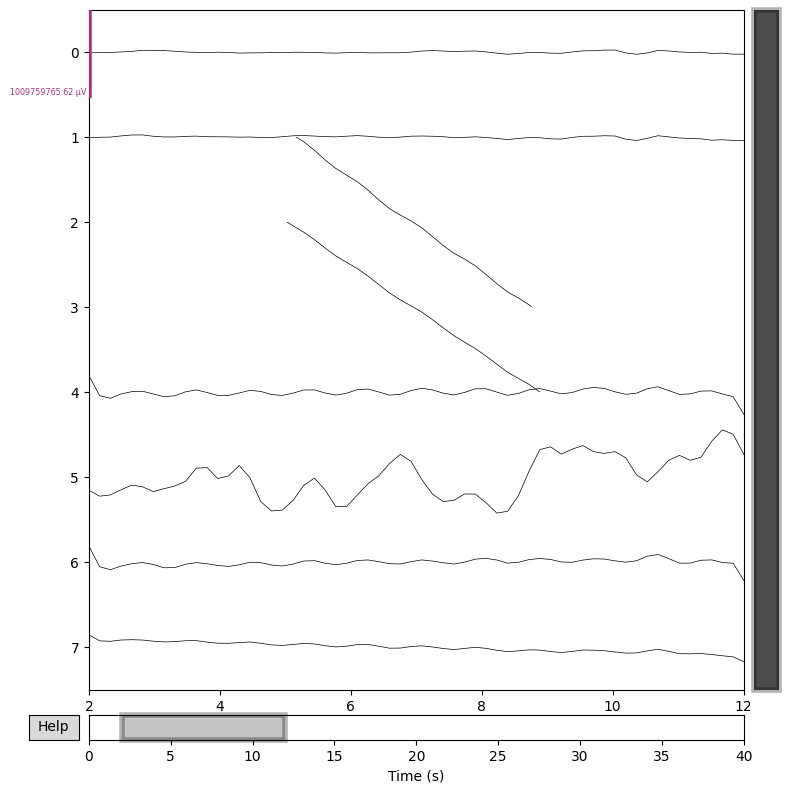

In [41]:
# show bad channel example
# notice the missing/skewed values for channel 2 and 3 --> is it a blink?
raw = current_baseline_mne_list[0]
print(raw)
raw.plot(scalings='auto', duration=10, start=2, n_channels=8, highpass=60, lowpass=2, clipping='transparent');

<RawArray | 8 x 10001 (40.0 s), ~638 kB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  0     EEG   µV    216116171875.00  216183312500.00  216211109375.00  216238203125.00  216318578125.00
 1  1     EEG   µV    198510406250.00  198623781250.00  198689671875.00  198756906250.00  198883500000.00
 2  2     EEG   µV    343870062500.00  347976343750.00  352415687500.00  357466187500.00  363480875000.00
 3  3     EEG   µV    338257625000.00  342202437500.00  346463937500.00  351243093750.00  356817187500.00
 4  4     EEG   µV    180593703125.00  180760437500.00  181016765625.00  181274718750.00  181453171875.00
 5  5     EEG   µV    158166671875.00  158981171875.00  160792375000.00  161212500000.00  161668484375.00
 6  6     EEG   µV    207878921875.00  208076515625.00  208303781250.00  208533656250.00  208694765625.00
 7  7     EEG   µV    170864078125.00  171176906250.00  171331500000.00  171488765625.00  171841468750.00
Describe:  None


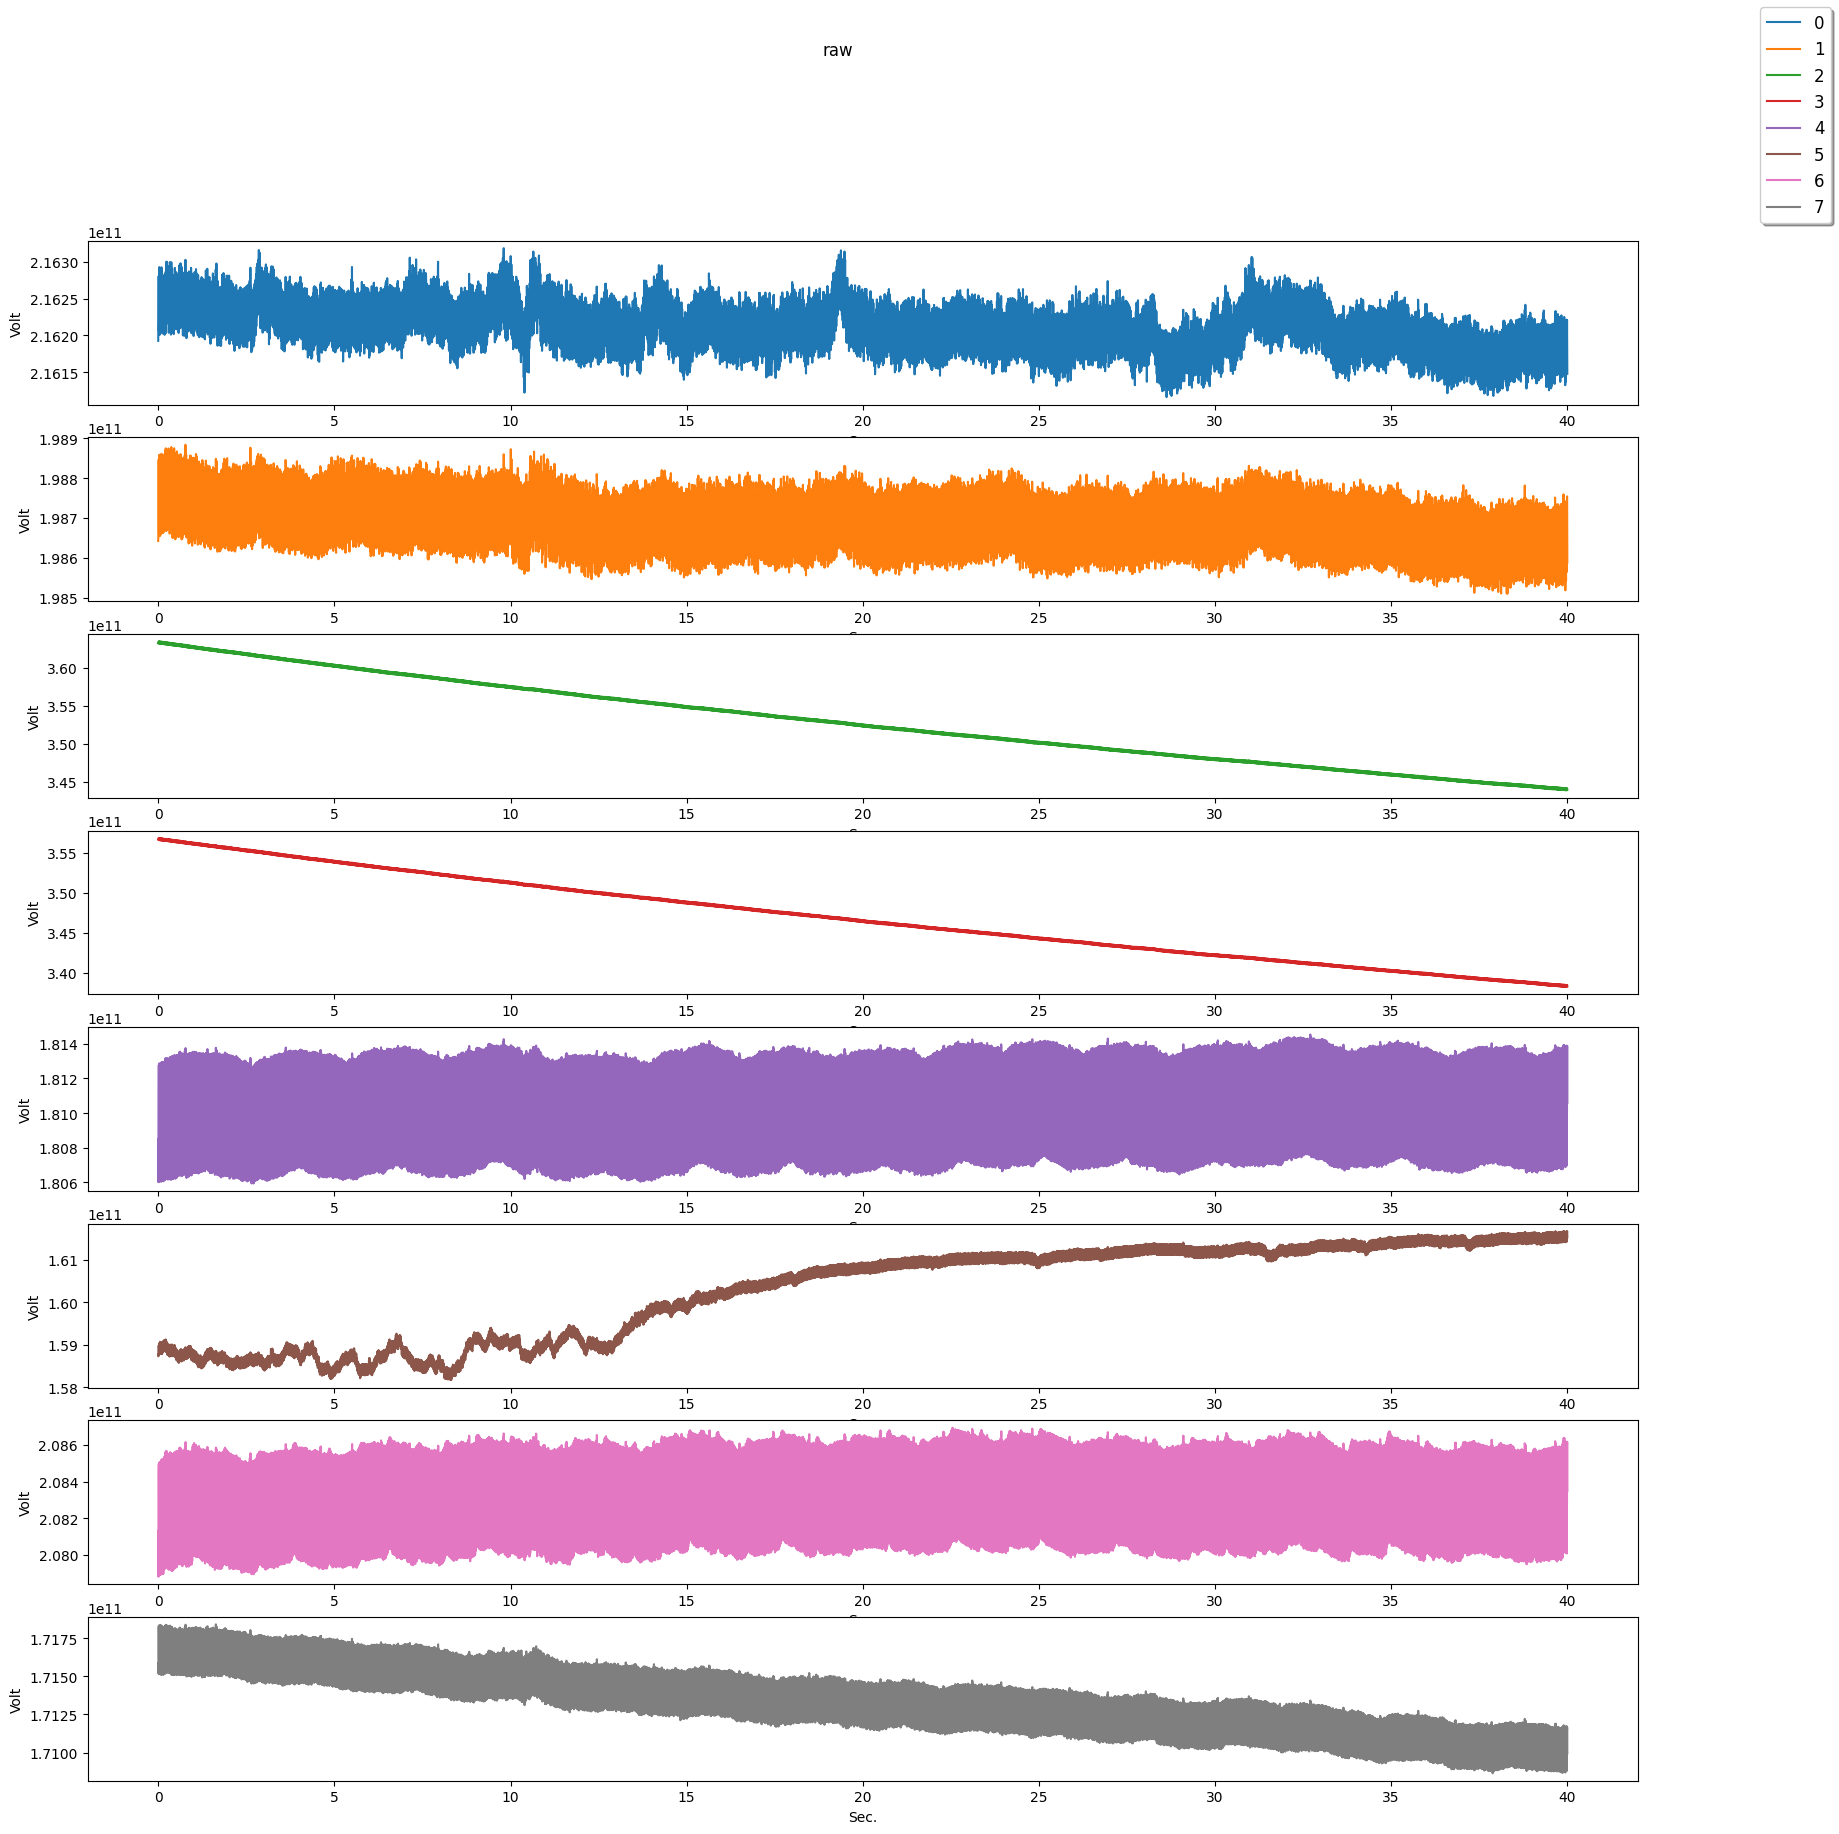

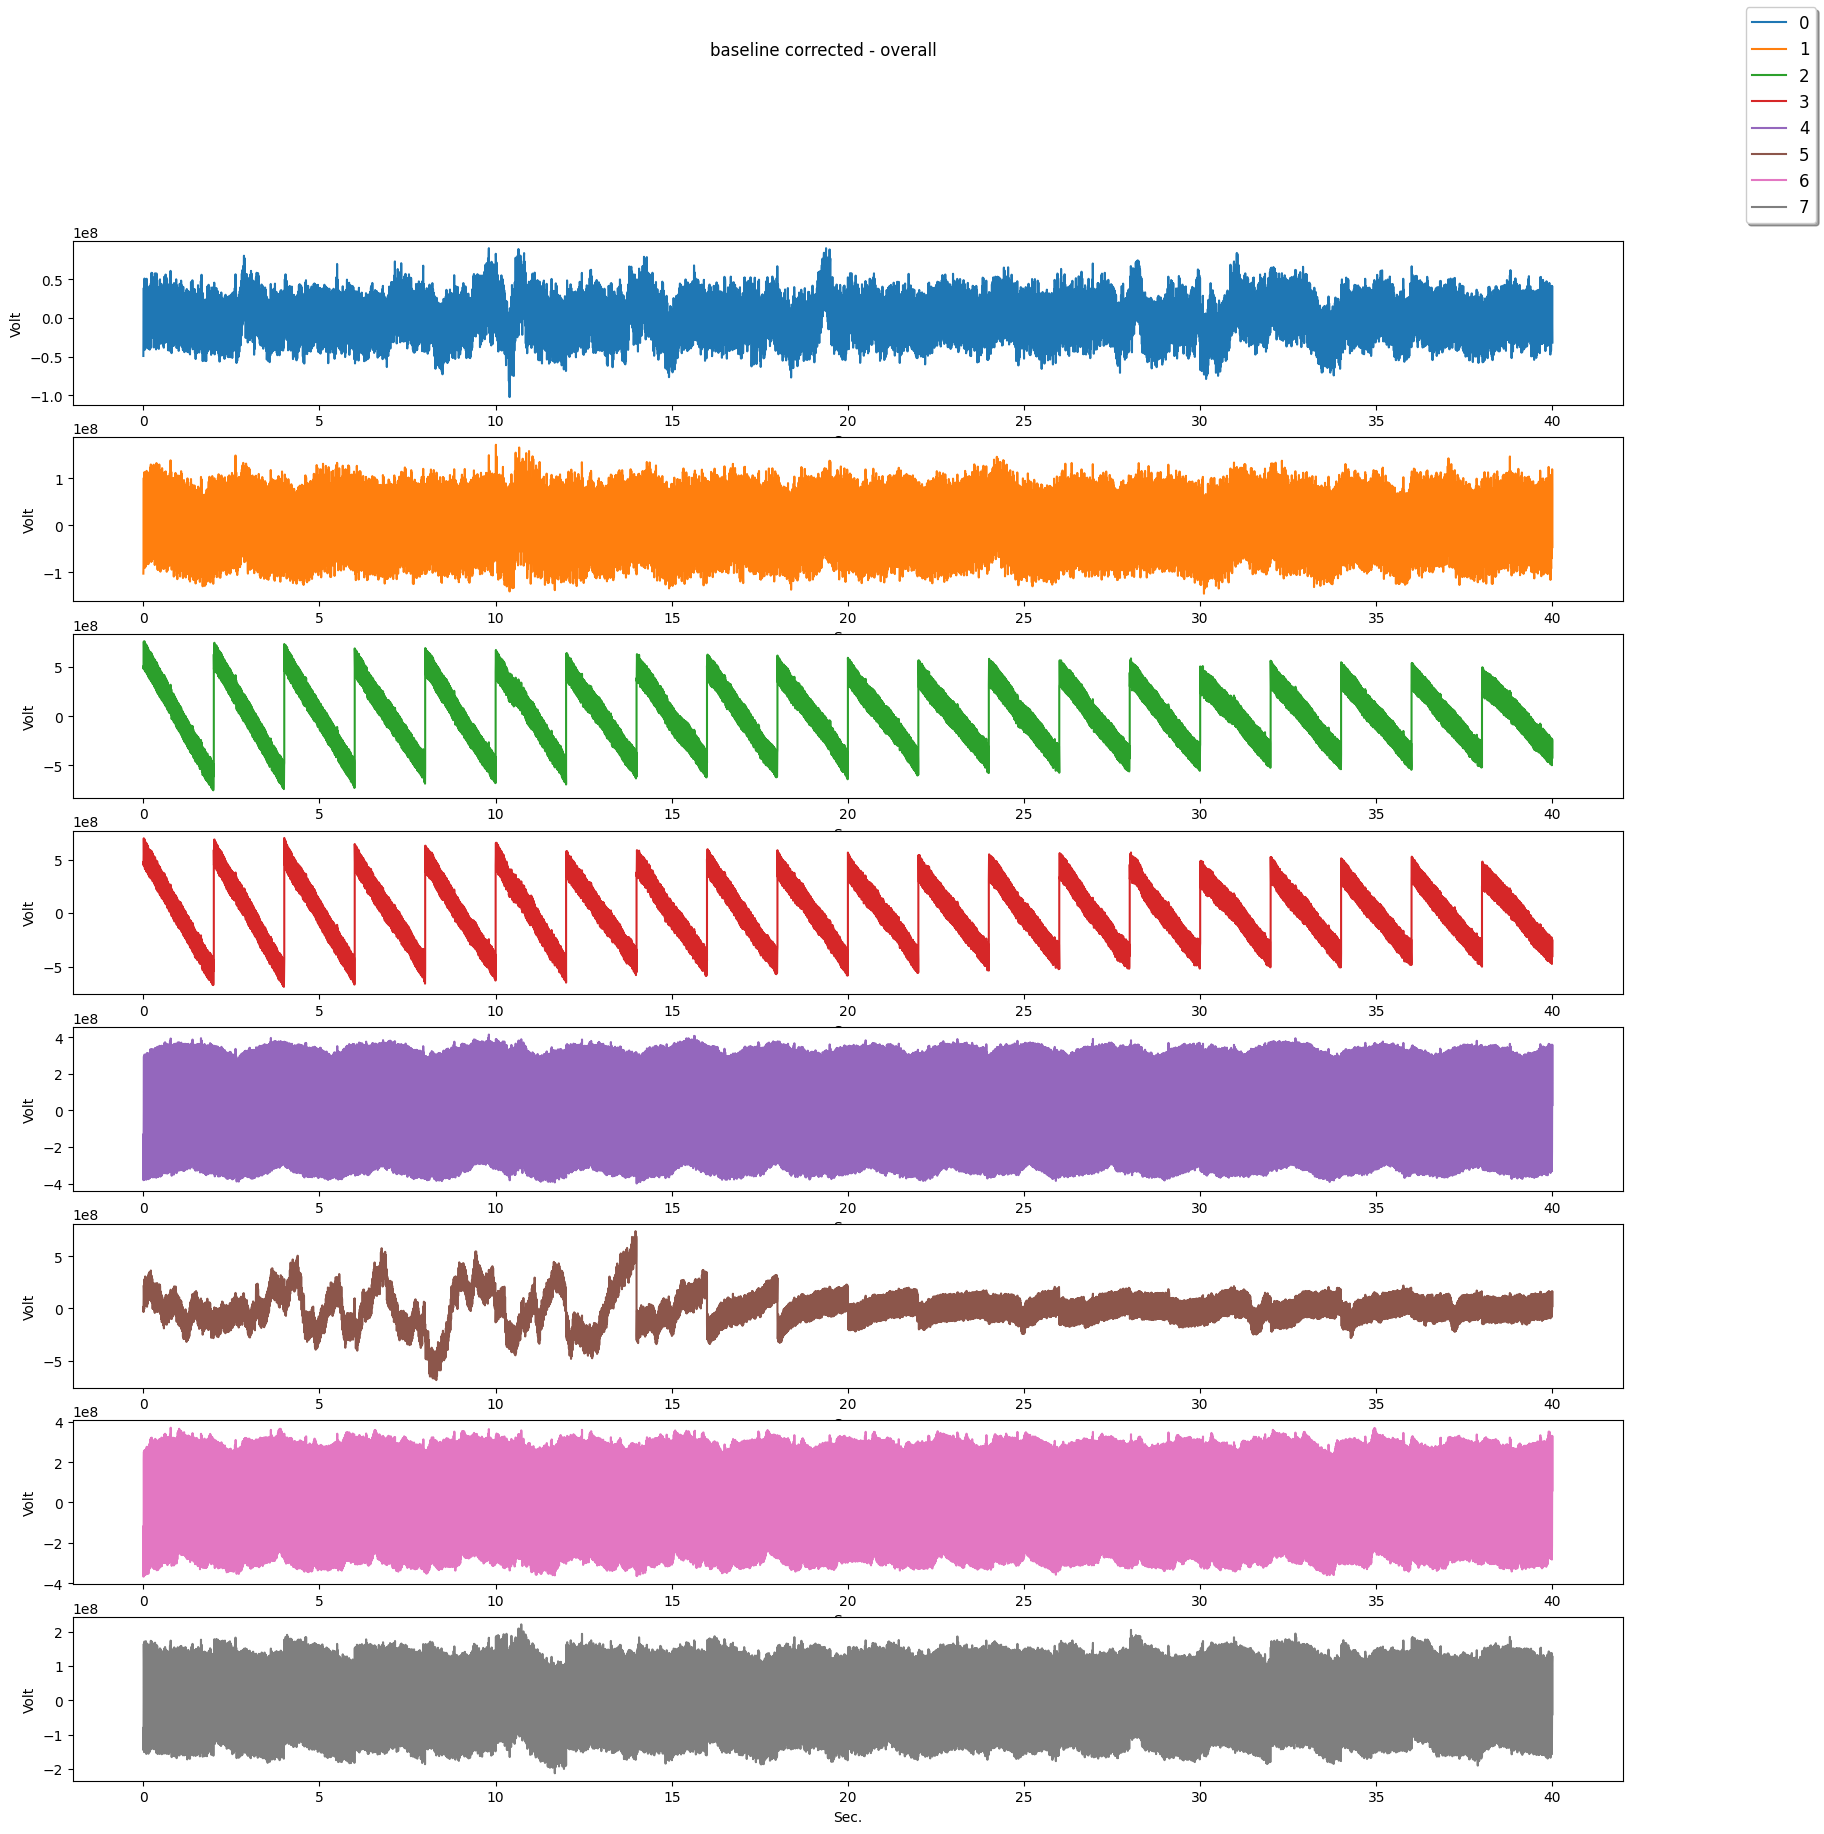

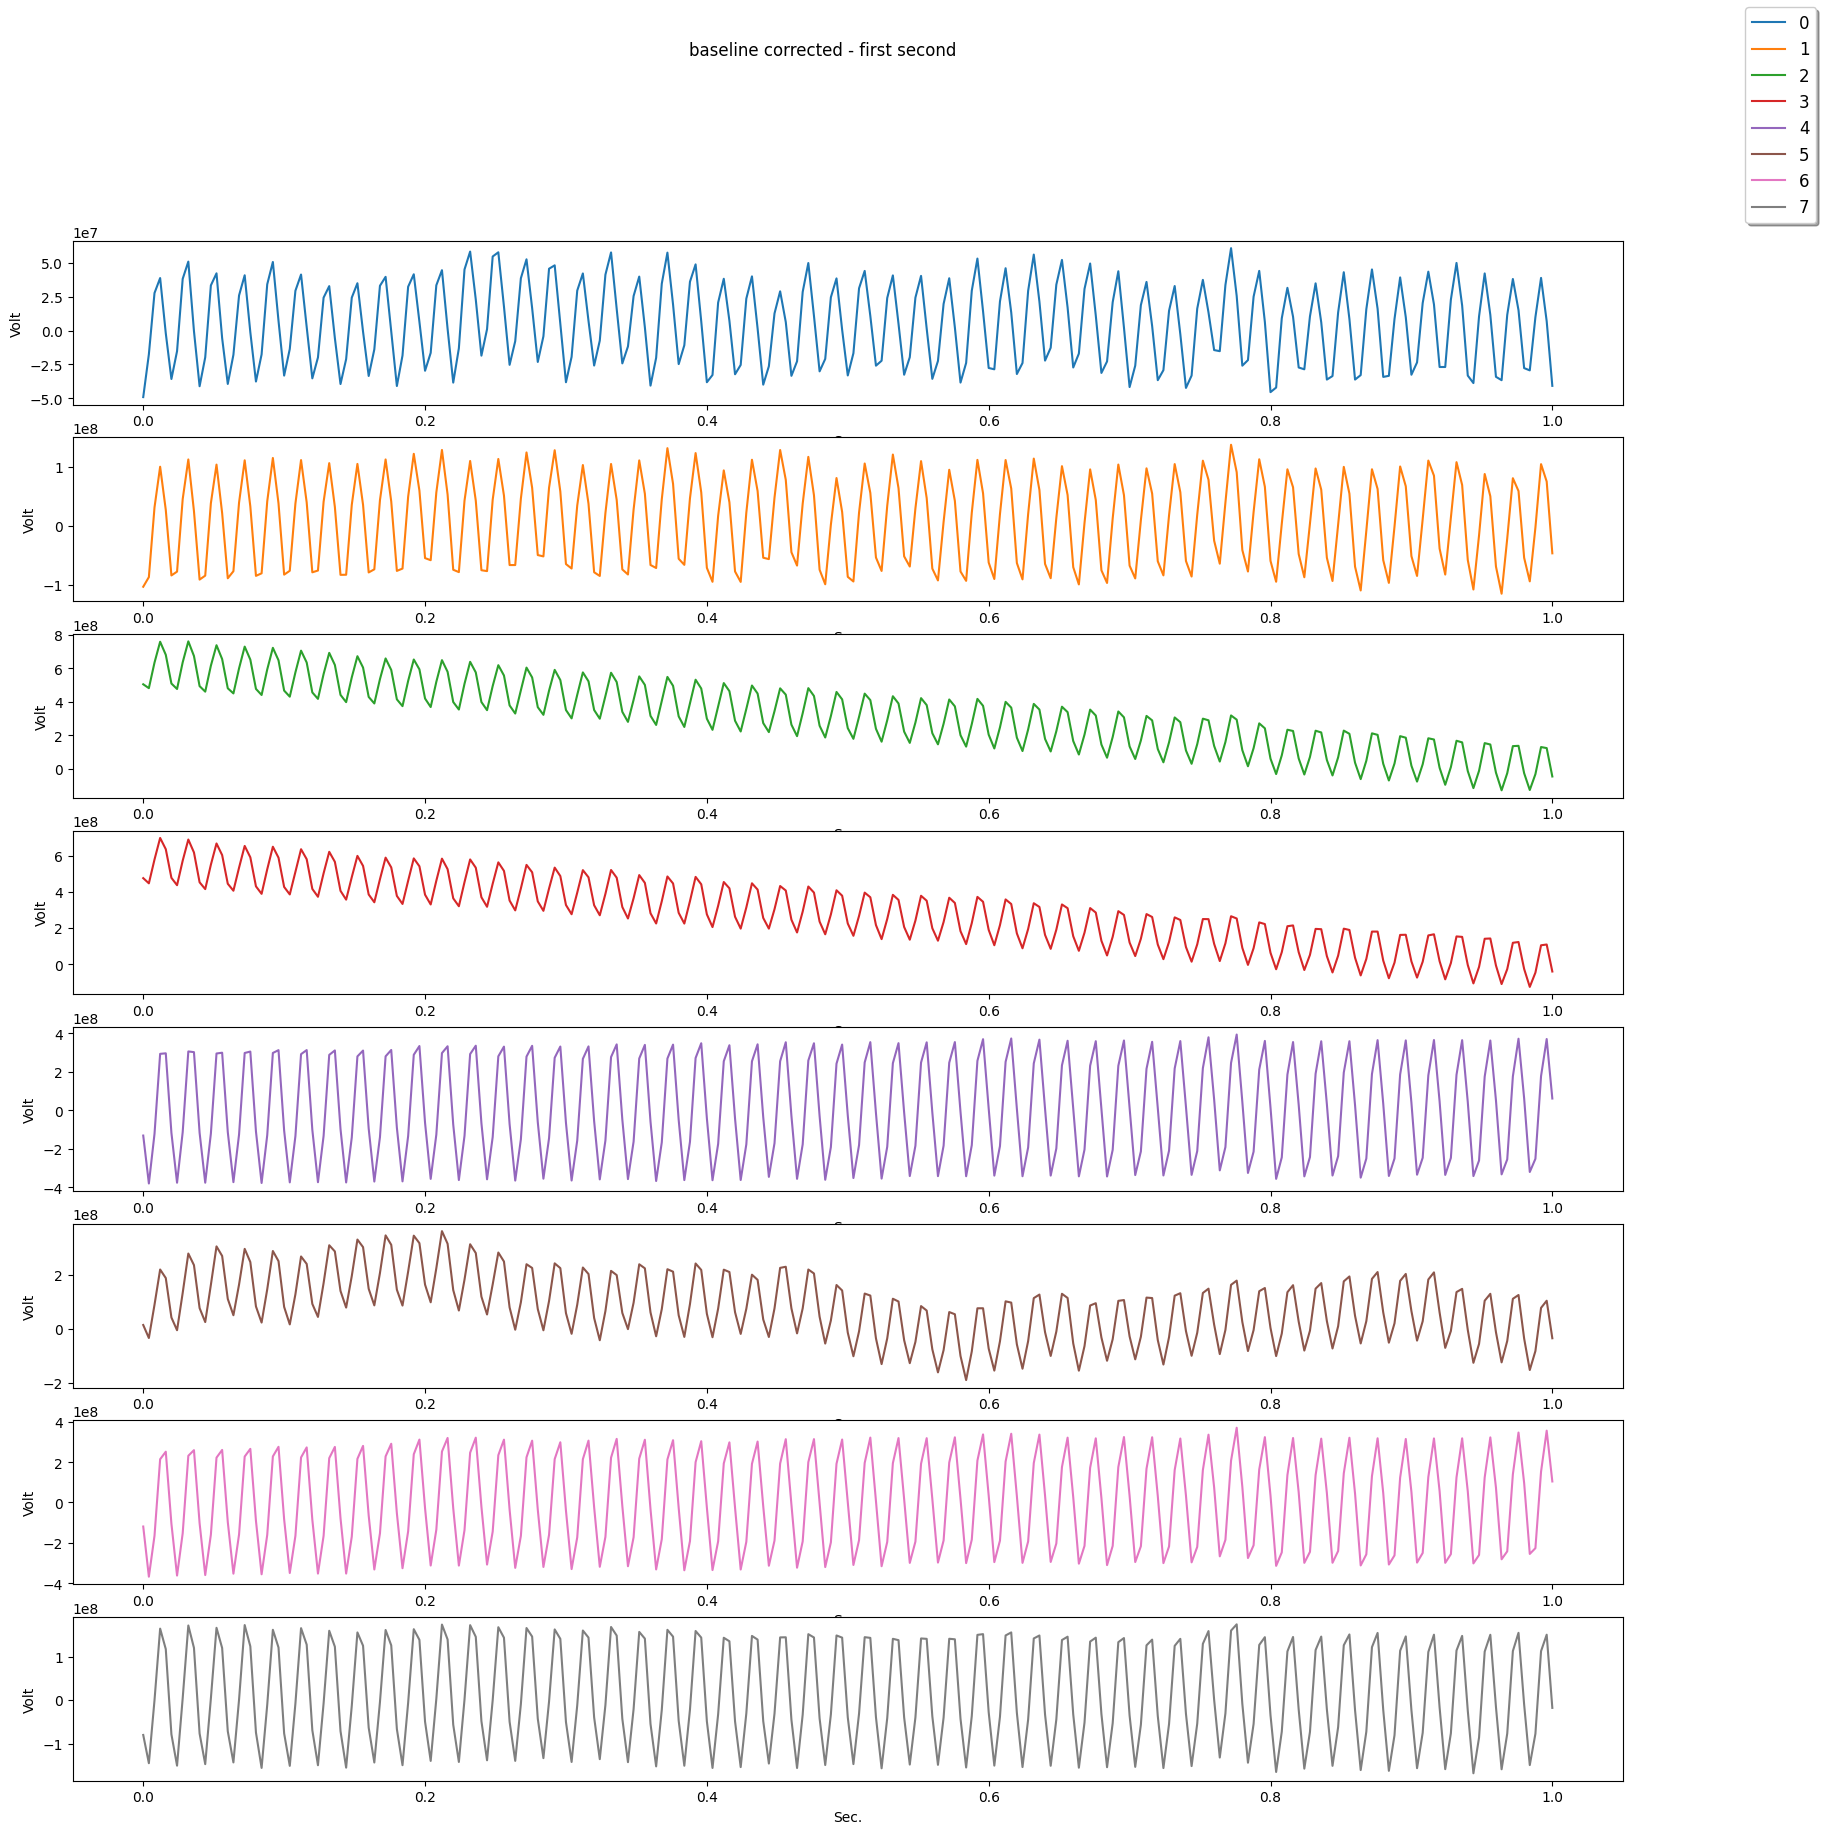

In [42]:
# baseline correction
# see https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/BaselineCorrection.html

def plotChannel(df: pd.DataFrame, title, tmin=0.0, tmax=40.0):

        fig, ax = plt.subplots(len(df.columns), figsize=(20, 20))

        for i, col in enumerate(df.columns):   
            ax[i].plot(df[(df.index >= tmin) & (df.index <= tmax)][col], label=col, color=[x for x in colors.TABLEAU_COLORS.values()][i])
            ax[i].set_xlabel('Sec.')
            ax[i].set_ylabel('Volt')
        legend = fig.legend(loc='upper right', shadow=True, fontsize='large')
        fig.suptitle(title)
        plt.show()

print("Describe: ", current_baseline_mne_list[0].describe())
df = raw.to_data_frame()
df.set_index('time', inplace=True)
plotChannel(df, 'raw')

bc = []
step = 2
for i in range(0, int(df.index.max()), step):
    tmin = i
    tmax = i+step
    mean = df[(df.index >= tmin) & (df.index <= tmax)].mean()
    bc.append(df[(df.index >= tmin) & (df.index <= tmax)] - mean)
df_bc = pd.concat(bc)

plotChannel(df_bc, 'baseline corrected - overall')
plotChannel(df_bc, 'baseline corrected - first second', 0, 1)
# convert back
#info = mne.create_info(8, 250, ["eeg"] * 8)
#test = mne.io.RawArray(df.T, info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



/tmp/ipykernel_1353420/1618761179.py:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


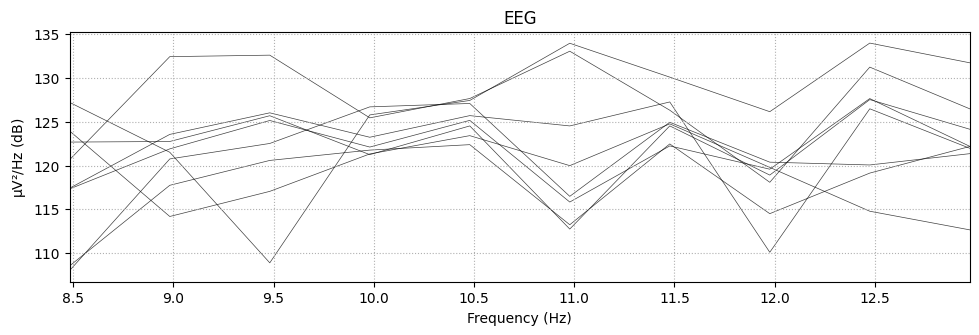

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.50
- Lower transition bandwidth: 3.38 Hz (-6 dB cutoff frequency: 11.81 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 245 samples (0.980 sec)



/tmp/ipykernel_1353420/1618761179.py:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


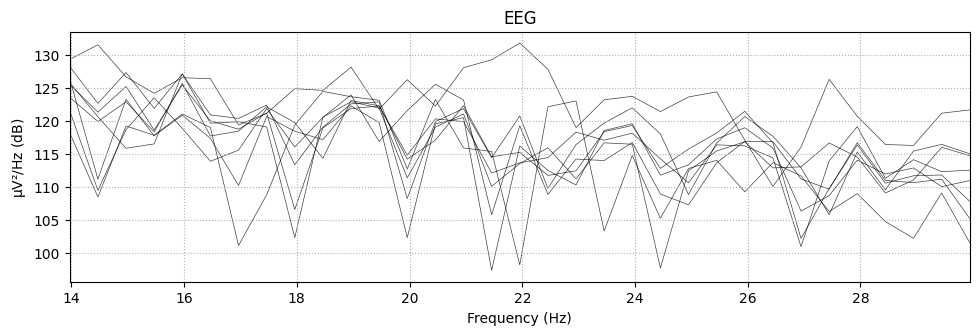

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.50
- Lower transition bandwidth: 7.62 Hz (-6 dB cutoff frequency: 26.69 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 109 samples (0.436 sec)



/tmp/ipykernel_1353420/1618761179.py:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)


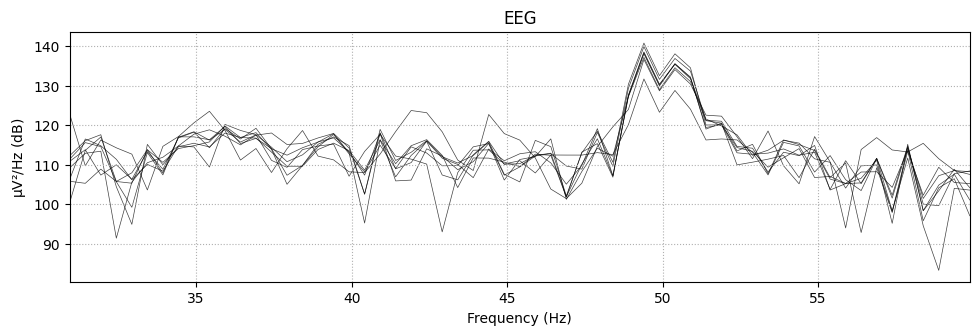

In [43]:
# plot relevant frequency bands

#specify participant
raw = current_baseline_mne_list[0]

# bands taken from slides
FREQ_BANDS = { 
                "alpha": [8, 13],
                "beta": [13.5, 30],
                "gamma": [30.5, 60],
            }

# apply notch filter
freqs = (50, 100)
raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)

raw_crop = raw_notch.copy().crop(tmin=0, tmax=2)
for band, freq in FREQ_BANDS.items():
    fmin, fmax = freq
    raw_filt = raw_crop.copy()
    raw_filt.filter(fmin, fmax, n_jobs=1)
    raw_filt.plot_psd(tmax=np.inf, fmin=fmin, fmax=fmax, verbose=False)

In [44]:
from mne.time_frequency import psd_welch


def eeg_power_band(raw: mne.io.RawArray):
    """EEG relative power band feature extraction.

    This function takes an ``mne.io.RawArray`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    raw : RawArray
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """

    # bands taken from slides
    fmin=8
    fmax=60
    FREQ_BANDS = {
        "alpha": [8, 13],
        "beta": [13.5, 30],
        "gamma": [30.5, 60],
    }

    psds, freqs = psd_welch(raw, picks="eeg", fmin=fmin, fmax=fmax, verbose=False)

    # Normalize the PSDs
    # Baseline in time dimension not neccessary (0th PSD dimension)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_mean = psds[:, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        psds_min = psds[:, (freqs >= fmin) & (freqs < fmax)].min(axis=-1)
        psds_max = psds[:, (freqs >= fmin) & (freqs < fmax)].max(axis=-1)
        psds_var = psds[:, (freqs >= fmin) & (freqs < fmax)].var(axis=-1)
        # IMPROVEMENT: use statistical features (min, max, var)
        # IDEA: use bins (e.g. 2 Hz range)
        X.append(psds_mean.reshape(len(psds), -1))
        X.append(psds_min.reshape(len(psds), -1))
        X.append(psds_max.reshape(len(psds), -1))
        X.append(psds_var.reshape(len(psds), -1))

    return np.concatenate(X, axis=-2).squeeze()  # concatenate all 8 channels * 3 frequences


In [45]:
# show a feature example
tmp = eeg_power_band(trials['ball'][0])
print(tmp.shape)
tmp


(96,)


array([8.74597993e-04, 1.82549110e-04, 7.74885565e-05, 9.38185801e-05,
       1.28019790e-05, 1.05996956e-04, 2.21077568e-05, 5.40367327e-05,
       5.55307982e-04, 1.28915640e-04, 4.91508700e-05, 5.02921846e-05,
       8.30502886e-06, 6.90306136e-05, 1.92200492e-05, 4.66185898e-05,
       1.26573443e-03, 2.67661442e-04, 9.20242270e-05, 1.31451955e-04,
       1.56757868e-05, 1.33512306e-04, 2.85408828e-05, 5.87103110e-05,
       8.10927164e-08, 3.05241628e-09, 2.22146202e-10, 8.85972838e-10,
       6.03486513e-12, 5.19414199e-10, 1.16846909e-11, 2.08502605e-11,
       3.42693211e-04, 6.18314436e-05, 3.61599254e-05, 3.81126667e-05,
       6.50428582e-06, 4.33669275e-05, 9.05006646e-06, 2.86779680e-05,
       2.04970120e-04, 2.86427253e-05, 1.37532943e-05, 2.05013453e-05,
       2.64919467e-06, 1.83128801e-05, 2.60086765e-06, 1.17177243e-05,
       5.51854337e-04, 1.07615810e-04, 7.51703670e-05, 6.22226339e-05,
       1.28799263e-05, 8.57171655e-05, 2.26774997e-05, 5.47323160e-05,
      

In [46]:
# create feature and class arrays

def create_ml_data(trails, step=2):
    X = []
    y = []
    for data_class, data_list in trails.items():
        for raw in data_list:

            # apply notch filter
            freqs = (50, 100)
            raw_notch = raw.copy().notch_filter(freqs=freqs, verbose=False, notch_widths=0.5)

            # slice and create psd
            for start in range(0, int(raw.tmax), step):
                raw_crop = raw.copy().crop(tmin=start, tmax=start+step)
                X.append(eeg_power_band(raw_crop))
                y.append(data_class)

    return X, y

X, y = create_ml_data(trials)

print(X[:1], len(X)) # 8 channels * 5 values
print(y[:1], len(y))


[array([1.49922537e-03, 2.70682398e-04, 1.21161289e-04, 1.36146783e-04,
       1.73493655e-05, 9.71109745e-05, 3.06941793e-05, 8.12245186e-05,
       4.08957344e-04, 4.91901928e-05, 4.25905936e-05, 2.30531635e-05,
       7.45122438e-06, 7.99441070e-05, 1.86200765e-05, 5.66311418e-05,
       4.40541495e-03, 4.74518446e-04, 1.94827523e-04, 3.12041640e-04,
       2.75227965e-05, 1.24049385e-04, 5.77427188e-05, 9.71124018e-05,
       2.22940548e-06, 2.78604261e-08, 2.59110606e-09, 9.73529120e-09,
       4.83735182e-11, 2.58220376e-10, 1.98020365e-10, 1.91522014e-10,
       4.73123714e-04, 8.83965890e-05, 5.21946871e-05, 3.93059158e-05,
       1.10377628e-05, 7.35607789e-05, 1.57520486e-05, 4.15877809e-05,
       8.11283463e-05, 1.36437748e-05, 2.53800407e-06, 8.39042766e-06,
       3.99386440e-07, 9.39130553e-06, 1.10218793e-06, 4.02078123e-06,
       9.01284123e-04, 2.27531630e-04, 1.35844247e-04, 7.84641839e-05,
       2.89166333e-05, 2.12410094e-04, 4.46027326e-05, 1.23160952e-04,
     

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.76
                   precision    recall  f1-score   support

             ball       0.75      0.75      0.75        12
      ball+number       0.80      0.71      0.75        17
ball+number+wheel       0.68      0.76      0.72        17
         baseline       1.00      1.00      1.00         4

         accuracy                           0.76        50
        macro avg       0.81      0.81      0.81        50
     weighted avg       0.76      0.76      0.76        50

[[ 9  0  3  0]
 [ 2 12  3  0]
 [ 1  3 13  0]
 [ 0  0  0  4]]


In [48]:
from sklearn.svm import SVC

pipe = make_pipeline(SVC(kernel= 'linear', random_state=42, C=0.1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.24
                   precision    recall  f1-score   support

             ball       0.24      1.00      0.39        12
      ball+number       0.00      0.00      0.00        17
ball+number+wheel       0.00      0.00      0.00        17
         baseline       0.00      0.00      0.00         4

         accuracy                           0.24        50
        macro avg       0.06      0.25      0.10        50
     weighted avg       0.06      0.24      0.09        50

[[12  0  0  0]
 [17  0  0  0]
 [17  0  0  0]
 [ 4  0  0  0]]


/home/weiss/.conda/envs/eeg-workshop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weiss/.conda/envs/eeg-workshop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weiss/.conda/envs/eeg-workshop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = make_pipeline(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train
pipe.fit(X_train, y_train)

# Test
y_pred = pipe.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.66
                   precision    recall  f1-score   support

             ball       0.67      0.67      0.67        12
      ball+number       0.62      0.59      0.61        17
ball+number+wheel       0.63      0.71      0.67        17
         baseline       1.00      0.75      0.86         4

         accuracy                           0.66        50
        macro avg       0.73      0.68      0.70        50
     weighted avg       0.67      0.66      0.66        50

[[ 8  2  2  0]
 [ 2 10  5  0]
 [ 2  3 12  0]
 [ 0  1  0  3]]


In [50]:
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

estimator = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    # tree_method="gpu_hist", # no gpu present
    )

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)
y_numeric

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, random_state=42)

# Train
estimator.fit(X_train, y_train)

# Test
y_pred = estimator.predict(X_test)

# Assess the results
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
print(classification_report(y_test, y_pred, target_names=trials.keys()))
print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.68
                   precision    recall  f1-score   support

             ball       0.60      0.75      0.67        12
      ball+number       0.73      0.65      0.69        17
ball+number+wheel       0.62      0.59      0.61        17
         baseline       1.00      1.00      1.00         4

         accuracy                           0.68        50
        macro avg       0.74      0.75      0.74        50
     weighted avg       0.69      0.68      0.68        50

[[ 9  1  2  0]
 [ 2 11  4  0]
 [ 4  3 10  0]
 [ 0  0  0  4]]


In [51]:
# find good parameters
# we limit this as we have limited ressources (time and hardware)

import xgboost as xgb
from sklearn.model_selection import  GridSearchCV, StratifiedKFold

estimator = xgb.sklearn.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='logloss',
    # tree_method="gpu_hist", # no gpu present
    )

param_grid = {
    'learning_rate': [.1, 0.2, 0.4],  # `eta` value
    #'max_depth': [4, 6, 8],
    #'min_child_weight': [1, 3, 5, 10],
    #'subsample': [0.7, 1],
    #'colsample_bytree': [0.7, 1],
    'n_estimators': [10, 20, 50, 100],
    #'gamma': [0.5, 1, 2]
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    estimator,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)

grid.fit(X, y_numeric) # takes too long

print(grid.best_params_)
print(grid.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'learning_rate': 0.2, 'n_estimators': 20}
0.68


In [52]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
import re

estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

param_grid = {
    "learning_rate": [0.2],
    "n_estimators": [100], #takes too long for big n of estimators, e.g. 1000!
}

mycv = StratifiedKFold(n_splits=10)

grid = GridSearchCV(
    estimator,
    param_grid,
    refit='accuracy',
    verbose=1,
    scoring=['accuracy'],
    cv=mycv
)

le = LabelEncoder()

# make predictions for all participants individually
for i, current in enumerate(baseline_list):
    current_baseline_list = [current]
    current_experiment_list = [experiment_list[i]]
    participant = re.findall(r"sub-(\w*)_ses", current_baseline_list[0])[0]

    trials = read_trails(current_experiment_list, current_baseline_list)
    X, y = create_ml_data(trials)

    y_numeric = le.fit_transform(y)
    grid.fit(X, y_numeric)
    print(f'mean accuracy for {participant} : {round(grid.best_score_, 2)}')

# make predictions for all participants collectively
current_baseline_list = baseline_list
current_experiment_list = experiment_list

trials = read_trails(current_experiment_list, current_baseline_list)
X, y = create_ml_data(trials)

y_numeric = le.fit_transform(y)
grid.fit(X, y_numeric)
print(f'mean accuracy for all participants : {round(grid.best_score_, 2)}')



Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Tobias : 0.6
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Karla : 0.64
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Jonah : 0.61
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Hussan : 0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Gaffar : 0.58
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Christian : 0.64
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Aljoscha : 0.66
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Oskar : 0.59
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for Timo : 0.48
Fitting 10 folds for each of 1 candidates, totalling 10 fits
mean accuracy for all participants : 0.38
